In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy import stats
import random
import quspin
import os
import time

In [4]:
np.set_printoptions(suppress=True,precision=3)
from quspin.basis import spin_basis_1d
from quspin.operators import hamiltonian

We now construct an XXZ Hamiltonian in this basis.
\begin{equation*}
    H = \sum_{i=1}^{L-1} S_i^xS_{i+1}^x+S_i^yS_{i+1}^y+J_{zz}S^z_iS^z_{i+1}
\end{equation*}
Here, 

$S^x = \frac{1}{2} \sigma^x $
$S^y = \frac{1}{2} \sigma^y $
$S^z = \frac{1}{2} \sigma^z $

And the lower index indicates the lattice on which the operator acts

We can add a Next-to-Nearest-Neighbour (NNN) interaction term to it as follows
\begin{equation*}
    \tilde{H} = \sum_{i=1}^{L-1} S_i^xS_{i+1}^x+S_i^yS_{i+1}^y+J_{zz}S^z_iS^z_{i+1}+J_{ch}\sum_{i=1}^{L-2}S_i^xS_{i+2}^x+S_i^yS_{i+2}^y
\end{equation*}

In [5]:
def XXZHamiltonian(L,M,J_zz,J_ch): #returns hamiltonian in the standard basis
    basis = spin_basis_1d(L=L,Nup = M)
    op_list_xy = [[1/4,i,i+1]for i in range(0,L-1)]#integrable terms of the Hamiltonian
    op_list_zz = [[J_zz/4,i,i+1]for i in range(0,L-1)]

    if J_ch == 0:
        static = [["xx",op_list_xy],["yy",op_list_xy],["zz",op_list_zz]]

        H_XXZ = hamiltonian(static,[],basis = basis)
        return H_XXZ
    else:
        op_list_xy_NNN = [[J_ch/4,i,i+2]for i in range(0,L-2)]

        static = [["xx",op_list_xy],["yy",op_list_xy],["zz",op_list_zz],["xx",op_list_xy_NNN],["yy",op_list_xy_NNN]]

        H_XXZ_NNN = hamiltonian(static,[],basis = basis)
        return H_XXZ_NNN

In [7]:
H_ch = XXZHamiltonian(20,8,0.5,1.0)
print(H_ch)

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
static mat: 
<Compressed Sparse Row sparse matrix of dtype 'complex128'
	with 2480946 stored elements and shape (125970, 125970)>
  Coords	Values
  (0, 0)	(2.125+0j)
  (0, 1)	(0.5+0j)
  (0, 2)	(0.5+0j)
  (0, 13)	(0.5+0j)
  (1, 0)	(0.5+0j)
  (1, 1)	(1.625+0j)
  (1, 2)	(0.5+0j)
  (1, 3)	(0.5+0j)
  (1, 13)	(0.5+0j)
  (1, 91)	(0.5+0j)
  (2, 0)	(0.5+0j)
  (2, 1)	(0.5+0j)
  (2, 2)	(1.625+0j)
  (2, 3)	(0.5+0j)
  (2, 4)	(0.5+0j)
  (2, 14)	(0.5+0j)
  (2, 25)	(0.5+0j)
  (2, 92)	(0.5+0j)
  (3, 1)	(0.5+0j)
  (3, 2)	(0.5+0j)
  (3, 3)	(1.625+0j)
  (3, 4)	(0.5+0j)
  (3, 5)	(0.5+0j)
  (3, 15)	(0.5+0j)
  (3, 26)	(0.5+0j)
  :	:
  (125966, 125951)	(0.5+0j)
  (125966, 125958)	(0.5+0j)
  (125966, 125964)	(0.5+0j)
  (125966, 125965)	(0.5+0j)
  (125966, 125966)	(1.625+0j)
  (125966, 125967)	(0.5+0j)
  (125966, 125968)	(0.5+0j)
  (125967, 125923)	(0.5+0j)
  (125967, 125952)	(0.5+0j)
  (125967, 125959)	(0.5+0j)
  (125967, 125

Implement the Lanczos algorithm

$\ket{A_{n+1}} = (H-a_n)\ket{K_n}-b_n\ket{K_n-1}$

$a_n=\bra{K_n}H\ket{K_n}$

$b_n = \braket{A_n|A_n}^{1/2}$

In [ ]:
def getLangczoscoeffs(basis,H,psi_0):#returns tuple: a_ns, b_ns, K_ns

    dim = basis.Ns
    a_0 = psi_0.conj()@(H.dot(psi_0)) #<K_0|H|K_0>
    b_0 = 0

    A_1 = H.dot(psi_0)-a_0*psi_0 #(H-a_0)|K_0>
    b_1 = np.linalg.norm(A_1)
    K_1 = A_1/b_1
    a_1 = K_1.conj()@(H.dot(K_1))#<K_1|H|K_1>

    K_ns = np.array([psi_0,K_1,]) #the Krylov basis vectors
    a_ns = np.array([a_0,a_1,])#Lanczos coefficients
    b_ns = np.array([b_0,b_1,])
    b_np1 = 1
    n=1
    tol = 10**(-6)

    while np.abs(b_np1)>tol and n < dim:
        K_n = K_ns[n]
        K_nm1 = K_ns[n-1]
        A_np1 = H.dot(K_n)-a_ns[n]*K_n-b_ns[n]*K_nm1 # H|K_n> - a_n |K_n> - b_n|K_n-1>

        non_orthogonal=[(A_np1.conj()@K_ns[i])* K_ns[i] for i in range(len(K_ns))]#reorthogonalisation
        A_np1 -= sum(non_orthogonal)


        b_np1 = np.linalg.norm(A_np1)
        if np.abs(b_np1)>tol:
            K_np1 = A_np1/b_np1
            a_np1 = K_np1.conj()@H.dot(K_np1)

            b_ns=np.append(b_ns,b_np1)
            a_ns=np.append(a_ns,a_np1)
            K_ns=np.append(K_ns,[K_np1],axis=0)

        n+=1
    return a_ns, b_ns, K_ns

In [ ]:
def getKComplexity(a_ns,b_ns,max_time,dt):
    N = len(a_ns)
    Hk = np.zeros((N, N), dtype=complex)#creates the Hamiltonian in Krylov basis
    for n in range(N):
        Hk[n, n] = a_ns[n]
        if n + 1 < N:
            Hk[n, n+1] = b_ns[n+1]
            Hk[n+1, n] = b_ns[n+1]
    
    psi_0 = np.zeros(N, dtype=complex)
    psi_0[0] = 1.0

    psi_t = [psi_0]
    ts = [0]
    U = expm(-1j*Hk*dt)

    while ts[-1]<max_time:
        ts.append(ts[-1]+dt)
        psi_t.append(U.dot(psi_t[-1]))#time evolution of the initial state
    
    phi_n = np.transpose(np.array(psi_t)) #getting the phi_n functions from the time evolution
    print("size of phi_n is:"+str(phi_n.shape))
    abs_phi_n = phi_n.conj()*phi_n#|phi_n|^2
    print("beginning to sum the complexity")
    C_k = sum([n*abs_phi_n[n] for n in range(len(abs_phi_n))])

    return C_k,ts



    

In [18]:


lengths = []
times = []
H_dims = []
for L in range(9,16,1):
    if L%2 == 0:
        M=int(L/2+1)
    else:
        M = int((L+1)/2)
    basis = spin_basis_1d(L=L,Nup = M)
    dim = basis.Ns #dimension of Hilbert space
    print(basis)

    psi_0 = (np.zeros(dim))
    psi_0[0]=1
    psi_0/= np.linalg.norm(psi_0)
    print(psi_0.conj()@psi_0)
    print(psi_0)

    os.system(f"mkdir CSV_Outputs\\Lanczos_Coefficients\\L{L}M{M}chain") #makes the directory for this length of chain and number of spinups

    #g_s = [2.0,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3.0,3.1,3.2,3.3,3.4,3.5,3.6,3.7,3.8,3.9,4.0]
    now = time.time()
    g_s = [0.0,0.5,1.0]
    for g in np.round(g_s,2):
        os.system(f"mkdir CSV_Outputs\\Lanczos_Coefficients\\L{L}M{M}chain\\chaos_coefficient{g}")
        H = XXZHamiltonian(L,M,0.01,g)

        a_ns, b_ns, K_ns = getLangczoscoeffs(basis,H,psi_0)
        np.savetxt(f"CSV_Outputs/Lanczos_Coefficients/L{L}M{M}chain/chaos_coefficient{g}/a_ns.csv",a_ns.real,delimiter = ",")
        np.savetxt(f"CSV_Outputs/Lanczos_Coefficients/L{L}M{M}chain/chaos_coefficient{g}/b_ns.csv",b_ns.real,delimiter = ",")
        np.savetxt(f"CSV_Outputs/Lanczos_Coefficients/L{L}M{M}chain/chaos_coefficient{g}/K_ns.csv",K_ns.real,delimiter = ",")
    later = time.time()

    H_dims.append(dim)
    lengths.append((L,M))
    times.append(later - now)

np.savetxt(f"CSV_Outputs/Lanczos_Coefficients/Time_scaling/H_dims.csv",np.array(H_dims),delimiter = ",")
np.savetxt(f"CSV_Outputs/Lanczos_Coefficients/Time_scaling/times.csv",np.array(times),delimiter = ",")


#print(a_ns)
#print(b_ns)    

reference states: 
array index   /   Fock state   /   integer repr. 
   0.  |1 1 1 1 1 0 0 0 0>  496 
   1.  |1 1 1 1 0 1 0 0 0>  488 
   2.  |1 1 1 1 0 0 1 0 0>  484 
   3.  |1 1 1 1 0 0 0 1 0>  482 
   4.  |1 1 1 1 0 0 0 0 1>  481 
   5.  |1 1 1 0 1 1 0 0 0>  472 
   6.  |1 1 1 0 1 0 1 0 0>  468 
   7.  |1 1 1 0 1 0 0 1 0>  466 
   8.  |1 1 1 0 1 0 0 0 1>  465 
   9.  |1 1 1 0 0 1 1 0 0>  460 
  10.  |1 1 1 0 0 1 0 1 0>  458 
  11.  |1 1 1 0 0 1 0 0 1>  457 
  12.  |1 1 1 0 0 0 1 1 0>  454 
  13.  |1 1 1 0 0 0 1 0 1>  453 
  14.  |1 1 1 0 0 0 0 1 1>  451 
  15.  |1 1 0 1 1 1 0 0 0>  440 
  16.  |1 1 0 1 1 0 1 0 0>  436 
  17.  |1 1 0 1 1 0 0 1 0>  434 
  18.  |1 1 0 1 1 0 0 0 1>  433 
  19.  |1 1 0 1 0 1 1 0 0>  428 
  20.  |1 1 0 1 0 1 0 1 0>  426 
  21.  |1 1 0 1 0 1 0 0 1>  425 
  22.  |1 1 0 1 0 0 1 1 0>  422 
  23.  |1 1 0 1 0 0 1 0 1>  421 
  24.  |1 1 0 1 0 0 0 1 1>  419 
               :
 101.  |0 1 0 0 1 1 1 0 1>  157 
 102.  |0 1 0 0 1 1 0 1 1>  155 
 103.  |0 1 0 0 1 0 1 1

KeyboardInterrupt: 

In [20]:
np.savetxt(f"CSV_Outputs/Lanczos_Coefficients/H_dims.csv",np.array(H_dims),delimiter = ",")
np.savetxt(f"CSV_Outputs/Lanczos_Coefficients/times.csv",np.array(times),delimiter = ",")

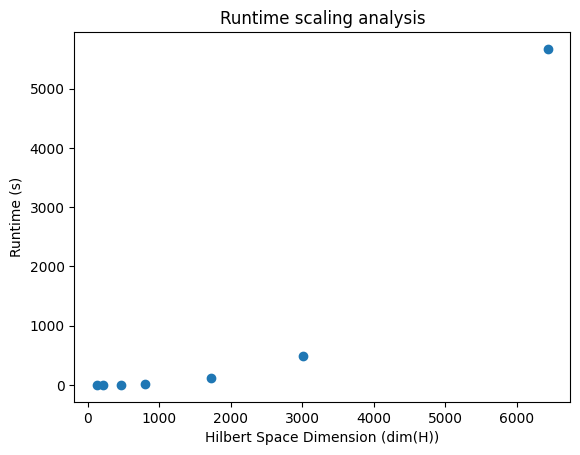

In [36]:
plt.scatter(np.array(H_dims),np.array(times))
plt.xlabel("Hilbert Space Dimension (dim(H))")
plt.ylabel("Runtime (s)")
plt.title("Runtime scaling analysis")
plt.savefig("Runtime_scaling _analysis_Lanczos.pdf")

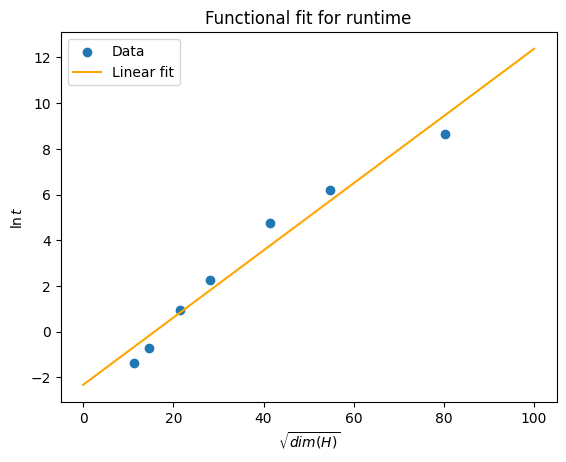

In [43]:
plt.scatter(np.sqrt(np.array(H_dims)),np.log(np.array(times)),label = "Data")

fit = stats.linregress(np.sqrt(np.array(H_dims)),np.log(np.array(times)))
dims = np.linspace(0,100)
plt.plot(dims,fit.slope*dims+fit.intercept,label = "Linear fit",color = "orange")

plt.legend()
plt.xlabel("$\sqrt{dim(H)}$")
plt.ylabel("$\ln t$")
plt.title("Functional fit for runtime")
plt.savefig("Runtime_scaling _analysis_Lanczos_linear_fit.pdf")

The linear fit here does not match exactly, but this is difficult to see without more datapoints


In [59]:
L=13
M=7
#fig,ax = plt.subplots()


#for g in g_s:

    #b_ns = np.loadtxt(f"CSV_Outputs/Lanczos_Coefficients/L{L}M{M}chain/chaos_coefficient{g}/b_ns.csv")
    #b_ns_g = np.loadtxt(f"CSV_Outputs/Lanczos_Coefficients/L{L}M{M}chain/chaos_coefficient{g}/b_ns.csv")

    #ax.plot(b_ns,label = f"g={g}")
    #plt.xlabel("n")
    #plt.ylabel("$b_n$")
#ax.legend()

#fig,ax = plt.subplots()
#g_s = np.arange(0.0,1.1,0.1)

L=13
M=7

g_s = [0.0]
for g in np.round(g_s,2):
    b_ns = np.loadtxt(f"CSV_Outputs/Lanczos_Coefficients/L{L}M{M}chain_gs/chaos_coefficient{g}/b_ns.csv")
    a_ns = np.loadtxt(f"CSV_Outputs/Lanczos_Coefficients/L{L}M{M}chain_gs/chaos_coefficient{g}/a_ns.csv")
    print("beginning to compute")
    C_ks, ts = getKComplexity(a_ns,b_ns,2000,0.01)
    print("finished computing")
    print("beginning to save")
    np.savetxt(f"CSV_Outputs/Lanczos_Coefficients/L{L}M{M}chain_gs/chaos_coefficient{g}/C_ksv2.csv",C_ks.real,delimiter = ",")
    np.savetxt(f"CSV_Outputs/Lanczos_Coefficients/L{L}M{M}chain_gs/chaos_coefficient{g}/ts.csv",ts,delimiter = ",")
    print("saved")
    #ax.plot(ts,C_ks,label = f"g = {g}")
    #plt.xlabel("t")
    #plt.ylabel("$C_k$")


#ax.legend()
    

beginning to compute
finished computing
beginning to save
saved


In [67]:
L=13
M=7
C_k = 0

g_s = [0.0]
for g in np.round(g_s,2):
    b_ns = np.loadtxt(f"CSV_Outputs/Lanczos_Coefficients/L{L}M{M}chain_gs/chaos_coefficient{g}/b_ns.csv")
    a_ns = np.loadtxt(f"CSV_Outputs/Lanczos_Coefficients/L{L}M{M}chain_gs/chaos_coefficient{g}/a_ns.csv")
    print("beginning to compute")

    dt = 0.01
    max_time = 2000

    N = len(a_ns)
    Hk = np.zeros((N, N), dtype=complex)#creates the Hamiltonian in Krylov basis
    for n in range(N):
        Hk[n, n] = a_ns[n]
        if n + 1 < N:
            Hk[n, n+1] = b_ns[n+1]
            Hk[n+1, n] = b_ns[n+1]
    
    psi_0 = np.zeros(N, dtype=complex)
    psi_0[0] = 1.0

    psi_t = np.array([psi_0])
    ts = [0]
    U = expm(-1j*Hk*dt)
    print("===========================")
    print("time evolving")
    while ts[-1]<max_time:
        ts.append(ts[-1]+dt)
        psi_t = np.append(psi_t,U.dot(psi_t[-1]))#time evolution of the initial state\
    print(psi_t.shape)
    print(len(ts))
    print("finished time evolving")
    print("===========================")

    print("transposing phi_n")
    phi_n = np.transpose(psi_t) #getting the phi_n functions from the time evolution
    psi_t=0
    print("finished transposing phi_n")
    print("===========================")

    print("size of phi_n" + str(phi_n.shape))
    print("getting abs_phi_n")
    abs_phi_n = []
    for n in range(len(phi_n)):
        abs_phi_n.append(phi_n[n].conj()*phi_n[n])
        phi_n[n]=0
    #phi_n.conj()*phi_n#|phi_n|^2
    print("finished getting abs_phi_n")
    print("===========================")

    print("getting the complexity")
    C_ks = 0
    for n in range(len(abs_phi_n)):
        C_ks+=n*abs_phi_n[n]
    #sum([n*abs_phi_n[n] for n in range(len(abs_phi_n))])
    print("finished getting the complexity")
    print("===========================")

    print("finished computing")
    print("===========================")

    print("beginning to save")
    np.savetxt(f"CSV_Outputs/Lanczos_Coefficients/L{L}M{M}chain_gs/chaos_coefficient{g}/C_ks.csv",C_ks.real,delimiter = ",")
    np.savetxt(f"CSV_Outputs/Lanczos_Coefficients/L{L}M{M}chain_gs/chaos_coefficient{g}/ts.csv",ts,delimiter = ",")
    print("saved")
    #ax.plot(ts,C_ks,label = f"g = {g}")
    #plt.xlabel("t")
    #plt.ylabel("$C_k$")

beginning to compute
time evolving


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (100001,) and (100002,)

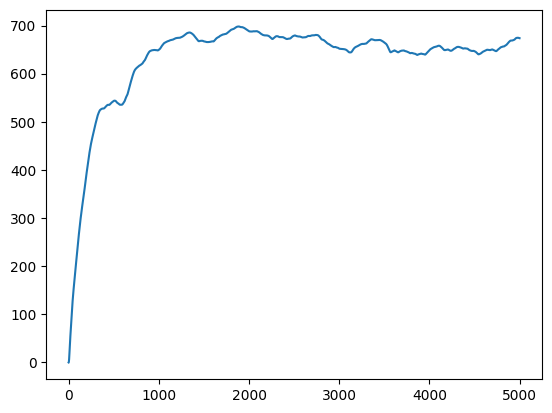

In [57]:
#g_s = [0.3,1.0,20.0]
g_s = [0.0]

for g in g_s:
    C_ks_load = np.loadtxt(f"CSV_Outputs/Lanczos_Coefficients/L{L}M{M}chain_gs/chaos_coefficient{g}/C_ksv2.csv",dtype = np.complex128).real
    C_ks_load2 = np.loadtxt(f"CSV_Outputs/Lanczos_Coefficients/L{L}M{M}chain_gs/chaos_coefficient{g}/C_ks.csv",dtype = np.complex128).real
    ts_load = np.loadtxt(f"CSV_Outputs/Lanczos_Coefficients/L{L}M{M}chain_gs/chaos_coefficient{g}/tsv2.csv")
    plt.plot(ts_load,C_ks_load,label = f"g= {g}")
    plt.plot(ts_load,C_ks_load2,label = f"g= 0")
    plt.xlabel("t")
    plt.ylabel("$C_k$")
    print(g)

plt.legend()



In [58]:
print(C_ks_load.shape)

(100001,)


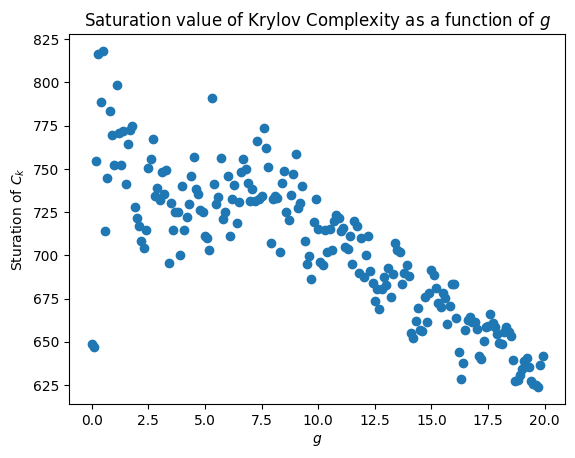

In [46]:
g_s = np.arange(0.0,20.0,0.1)
plateaus = []
for g in np.round(g_s,2):
    C_ks_load = np.loadtxt(f"CSV_Outputs/Lanczos_Coefficients/L{L}M{M}chain/chaos_coefficient{g}/C_ks.csv",dtype = np.complex128).real

    plateaus.append(np.average(C_ks_load[-2000:]))

plt.scatter(g_s,plateaus)
plt.xlabel("$g$")
plt.ylabel("Sturation of $C_k$")
plt.title("Saturation value of Krylov Complexity as a function of $g$")
plt.savefig("Saturation_value as function of g.pdf")